##### **NLP - HW3 - Part1**
##### Student name: **Majid Adibian**
##### Student number: **400131078**

In [ ]:
!pip install bert-embedding

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 22.0 MB/s 
     |████████████████████████████████| 29.6 MB 1.5 MB/s 
     |████████████████████████████████| 209 kB 53.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.6.0-py3-none-any.whl size=259930 sha256=8b48613bbf9b178070d224ea7cd9a60611ed7a39cebc5f6363e65cf6d77f62ce
  Stored in directory: /root/.cache/pip/wheels/a6/41/8f/45bd1c58055d87aee5a71b6756a427ea8d92e506b3a9d17370
Successfully built gluonnlp
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

##### Download data

In [ ]:
!gdown 1oin_Sw1Gk_WLS9zpDrap5FdlRcUrTP_D
!gdown 1EvtGQ8-sYXXQ3VA9ByjD4OmFH13WxvAs
!gdown 154f-z0PsPAp0yvOLdNXP8NXYjPljpgCZ
!gdown 1EDG_j6F5ohIjpkihRQd0-i9daHWV7StN

Downloading...
From: https://drive.google.com/uc?id=1oin_Sw1Gk_WLS9zpDrap5FdlRcUrTP_D
To: /content/Sentenses_train.txt
100% 1.23M/1.23M [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EvtGQ8-sYXXQ3VA9ByjD4OmFH13WxvAs
To: /content/Senses_train.txt
100% 49.7k/49.7k [00:00<00:00, 52.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=154f-z0PsPAp0yvOLdNXP8NXYjPljpgCZ
To: /content/Sentenses_test.txt
100% 213k/213k [00:00<00:00, 84.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EDG_j6F5ohIjpkihRQd0-i9daHWV7StN
To: /content/Senses_test.txt
100% 8.76k/8.76k [00:00<00:00, 9.51MB/s]


##### import packages

In [ ]:
from bert_embedding import BertEmbedding
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

### Step 1:

##### load data

In [ ]:
def get_sentences(path):
    f = open(path, 'r')
    lines = f.readlines()
    return [line.strip() for line in lines]

def get_labels(path):
    f = open(path, 'r')
    lines = f.readlines()
    return [line.strip() for line in lines]

train_sentences = get_sentences('Sentenses_train.txt')
train_labels = get_labels('Senses_train.txt')

##### Get embeddings of words from Bert and decompose them by PCA

In [ ]:
def get_word_embedding(lines, pca=None):
    bert_embedding = BertEmbedding()
    ambiguite_words = []
    cleaned_lines = []
    for line in lines:
        line = line.lower()
        words = line.split()
        hard_index  = -1
        for i, word in enumerate(words):
            if 'hard' == word:
                hard_index = i
                break
        if hard_index != -1:
            ambiguite_word = words[hard_index].strip()
            ambiguite_words.append(ambiguite_word)
            local_words = words[max(hard_index-10, 0) : min(hard_index+10, len(words))]
        else:
            ambiguite_word = words[words.index('<head>') + 1].strip()
            ambiguite_words.append(ambiguite_word)
            local_words = words[max(words.index('<head>')-10, 0) : min(words.index('</head>')+10, len(words))]
        try:
            local_words.remove('<head>')
            local_words.remove('</head>')
        except:
            pass
        cleaned_line = ' '.join(local_words)
        cleaned_lines.append(cleaned_line)
      
    embeddings = bert_embedding(cleaned_lines)
    
    words_embeddings = []
    for i, embedding in enumerate(embeddings):
        word_index = embedding[0].index(ambiguite_words[i])
        word_embedding = embedding[1][word_index]
        words_embeddings.append(word_embedding)
    
    if pca is None:
        pca = PCA(n_components=300)
        words_embeddings = pca.fit_transform(words_embeddings)
    else:
        words_embeddings = pca.transform(words_embeddings)
    return ambiguite_words, words_embeddings, cleaned_lines, pca

In [ ]:
ambiguite_words, words_embeddings, cleaned_lines, pca = get_word_embedding(train_sentences)

##### Save embeddings

In [ ]:
import pickle
main_path = '/content/drive/MyDrive/Colab Notebooks/NLP_HWs/HW3/'
info = {'ambiguite_words': ambiguite_words, 'words_embeddings': words_embeddings, 'cleaned_lines': cleaned_lines, 'pca': pca}
f = open(main_path + "info.pkl", "wb")
pickle.dump(info, f)
f.close()

##### load embeddings

In [ ]:
import pickle
main_path = '/content/drive/MyDrive/Colab Notebooks/NLP_HWs/HW3/'
f = open(main_path + "info.pkl", "rb")
info = pickle.load(f)
f.close()
ambiguite_words, words_embeddings, cleaned_lines = info['ambiguite_words'], info['words_embeddings'], info['cleaned_lines']

### Step 2:

##### Split data and labels for any ambiguite words and then split train and validation data

In [ ]:
def find_stem(ambiguite_words):
    words2stem = {}
    for word1 in ambiguite_words:
        similar_words = []
        for word2 in ambiguite_words:
            if word2 in word1:
                similar_words.append(word2)
        words2stem[word1] = min(similar_words, key=len)
    return words2stem

def get_data_per_clf(data, labels, clf_name, words2stem):
    data_per_clf = {}
    labels_per_clf = {}
    for i, vec in enumerate(data):
        word_stem = words2stem[clf_name[i]]
        if word_stem in data_per_clf.keys():
            data_per_clf[word_stem].append(vec)
            labels_per_clf[word_stem].append(labels[i])
        else:
            data_per_clf[word_stem] = [vec]
            labels_per_clf[word_stem] = [labels[i]]
    clf_names = data_per_clf.keys()
    tag2id = {tag:i for i, tag in enumerate(list(set(clf_names)))}
    id2tag = {i:tag for i, tag in tag2id.items()}
    return data_per_clf, labels_per_clf, tag2id, id2tag

def split_train_val(data_per_clf, labels_per_clf, split_percent):
    labels_count = {}
    for clf in labels_per_clf.keys():
        for label in labels_per_clf[clf]:
            if label in labels_count.keys():
                labels_count[label] += 1
            else:
                labels_count[label] = 1
    val_data, val_label = {clf:[] for clf in data_per_clf.keys()}, {clf:[] for clf in data_per_clf.keys()}
    train_data, train_label = {clf:[] for clf in data_per_clf.keys()}, {clf:[] for clf in data_per_clf.keys()}
    val_label_count = {label:0 for label in labels_count.keys()}
    for clf in data_per_clf.keys():
        for i, vec in enumerate(data_per_clf[clf]):
            label = labels_per_clf[clf][i]
            if val_label_count[label] < split_percent*labels_count[label]:
                val_data[clf].append(vec)
                val_label[clf].append(label)
                val_label_count[label] += 1
            else:
                train_data[clf].append(vec)
                train_label[clf].append(label)
    return train_data, train_label, val_data, val_label

words2stem = find_stem(ambiguite_words)
data_per_clf, labels_per_clf, tag2id, id2tag = get_data_per_clf(words_embeddings, train_labels, ambiguite_words, words2stem)
train_data, train_label, val_data, val_label = split_train_val(data_per_clf, labels_per_clf, 0.2)

##### Train SVM with different parameters and find best params by validation data

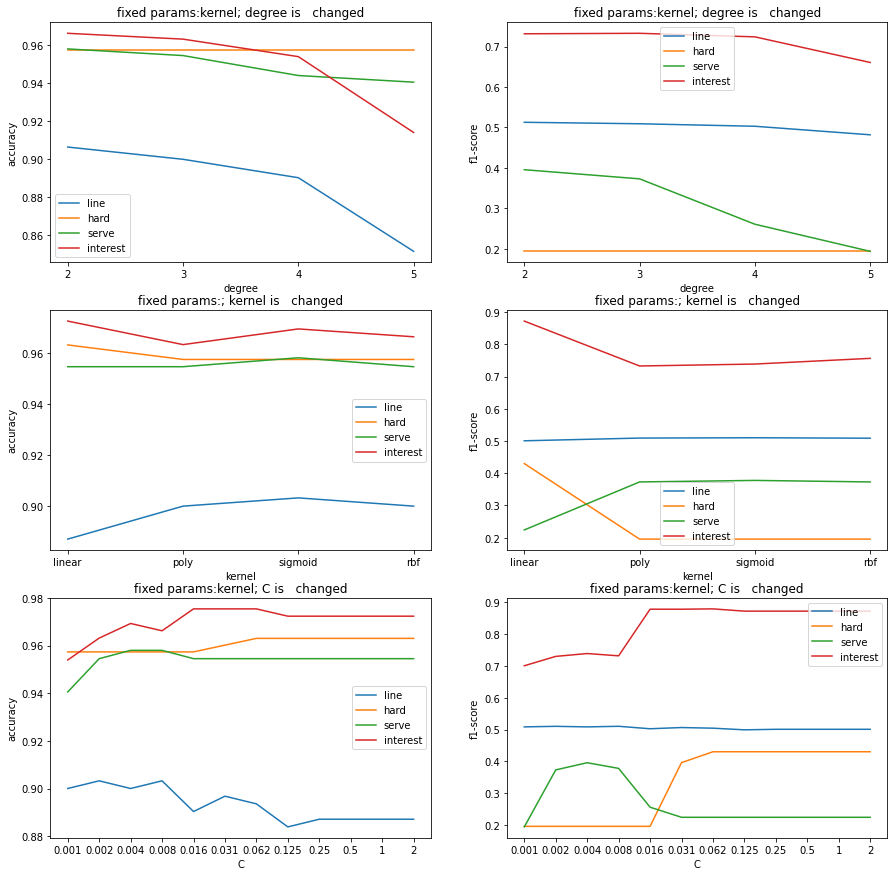

In [ ]:
def train_svm(data_per_clf, labels_per_clf, param):
    svm_per_ambiguite_word = {}
    for clf in data_per_clf.keys():
        if clf in param.keys():
            svm_clf = svm.SVC(**param[clf])
        else:
            svm_clf = svm.SVC(**param)
        svm_clf.fit(data_per_clf[clf], labels_per_clf[clf])
        svm_per_ambiguite_word[clf] = svm_clf
    return svm_per_ambiguite_word

def evaluate(svm_per_ambiguite_word, data, real_labels):
    scores_per_clf = {}
    for ambiguite_word, svm in svm_per_ambiguite_word.items():
        predicted_labels = svm.predict(data[ambiguite_word])
        accuracy = accuracy_score(real_labels[ambiguite_word], predicted_labels)
        f1 = f1_score(real_labels[ambiguite_word], predicted_labels, average='macro')
        scores_per_clf[ambiguite_word] = {'accuracy': accuracy, 'f1-score': f1}
    return scores_per_clf

def find_best_params(train_data, train_label, val_data, val_label):
    all_scores = {}
    all_params = {'degree':[{'kernel':'poly', 'degree':2}, {'kernel':'poly', 'degree':3}, {'kernel':'poly', 'degree':4}, {'kernel':'poly', 'degree':5}], 
                  'kernel':[{'kernel':'linear'},{'kernel':'poly'}, {'kernel':'sigmoid'}, {'kernel':'rbf'}],
                  'C':[{'C':round(2**i, 3), 'kernel':'linear'} for i in range(-10, 2)]}
    for k, params in all_params.items():
        scores = []
        for param in params:
            svm_per_ambiguite_word = train_svm(train_data, train_label, param=param)
            scores_per_clf = evaluate(svm_per_ambiguite_word, val_data, val_label)
            scores.append(scores_per_clf)
        all_scores[k] = scores

    fig, axs = plt.subplots(len(all_scores), 2, figsize=(15,15))
    for i, k in enumerate(all_scores.keys()):
        for clf in train_data.keys():
            axs[i][0].plot([all_scores[k][j][clf]['accuracy'] for j in range(len(all_scores[k]))], label=clf)
            axs[i][1].plot([all_scores[k][j][clf]['f1-score'] for j in range(len(all_scores[k]))], label=clf)
            axs[i][0].set_xticks([i for i in range(len(all_params[k]))])
            axs[i][1].set_xticks([i for i in range(len(all_params[k]))])
            axs[i][0].set_xticklabels([p[k] for p in all_params[k]])
            axs[i][1].set_xticklabels([p[k] for p in all_params[k]])

        fixed_param = [k for k in all_params[k][0].keys()]
        fixed_param.remove(k)
        title = 'fixed params:' + ' ,'.join(fixed_param) + '; ' + str(k) + ' is   changed'
        axs[i][0].title.set_text(title)
        axs[i][1].title.set_text(title)
        axs[i][0].legend()
        axs[i][1].legend()
        axs[i][0].set_xlabel(k)
        axs[i][1].set_xlabel(k)
        axs[i][0].set_ylabel('accuracy')
        axs[i][1].set_ylabel('f1-score')
    plt.show()

find_best_params(train_data, train_label, val_data, val_label)

In [ ]:
svm_with_best_param = train_svm(train_data, train_label, param={'line': {'kernel':'rbf', 'C':0.25}, 'hard': {'kernel':'linear', 'C':0.25}, 
                                                                     'serve': {'kernel':'linear', 'C':0.25},  'interest': {'kernel':'linear', 'C':0.25}})

##### Evaluation: Caculate accuracy and f1-score in test data with best parameters

In [ ]:
test_sentences = get_sentences('Sentenses_test.txt')
test_labels = get_labels('Senses_test.txt')
test_ambiguite_words, test_words_embeddings, _, _ = get_word_embedding(test_sentences, pca)

In [ ]:
test_data_per_clf, test_labels_per_clf, tag2id, id2tag = get_data_per_clf(test_words_embeddings, test_labels, test_ambiguite_words, words2stem)
test_scores = evaluate(svm_with_best_param, test_data_per_clf, test_labels_per_clf)
for clf in test_scores:
    print(clf + ':')
    print(test_scores[clf])

line:
{'accuracy': 0.9570815450643777, 'f1-score': 0.6865160757800916}
hard:
{'accuracy': 0.9716981132075472, 'f1-score': 0.2892512077294686}
serve:
{'accuracy': 0.9964285714285714, 'f1-score': 0.7996275605214153}
interest:
{'accuracy': 0.9403508771929825, 'f1-score': 0.7978162722293153}
